In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(vocab_size)
print(itos)

27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [7]:
import random
random.seed(42)
random.shuffle(words)

In [8]:
# building the dataset
block_size = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [9]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[i.item()] for i in x), '->', itos[y.item()])

... -> e
..e -> b
.eb -> r
ebr -> i
bri -> m
rim -> a
ima -> .
... -> h
..h -> i
.hi -> l
hil -> t
ilt -> o
lto -> n
ton -> .
... -> j
..j -> h
.jh -> e
jhe -> n
hen -> e
ene -> .


In [45]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])
    
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        if self.training:
            # compute mean and variance from current batch
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True, unbiased=True)
        else:
            # use running mean and variance for inference
            xmean = self.running_mean
            xvar = self.running_var
        
        # normalize the input
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class Flatten:

    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []

class Sequential:
    
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    def zero_grad(self):
        for layer in self.layers:
            for p in layer.parameters():
                p.grad = None


In [13]:
torch.manual_seed(42)

In [51]:
n_embed = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embed), Flatten(),
    Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters), 'parameters')
for p in parameters:
    p.requires_grad = True

12097 parameters


In [52]:
batch_size = 32
max_steps = 200000
lossi = []
for i in range(max_steps):
    # construct a mini-batch of data
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))  # 32 random indices
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch of data

    # forward pass
    X = model(Xb)
    loss = F.cross_entropy(X, Yb)  # (batch_size, vocab_size) vs (batch_size,)

    # backward pass
    model.zero_grad()  # reset gradients to zero
    loss.backward()  # compute gradients

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps}: {loss.item():.4f}")
    lossi.append(loss.item())

      0/200000: 3.2899
  10000/200000: 2.3387
  20000/200000: 1.8168
  30000/200000: 2.4433
  40000/200000: 2.0810
  50000/200000: 2.3474
  60000/200000: 1.9950
  70000/200000: 2.1827
  80000/200000: 2.1182
  90000/200000: 2.0194
 100000/200000: 2.0350
 110000/200000: 2.8211
 120000/200000: 2.2946
 130000/200000: 2.2038
 140000/200000: 2.1749
 150000/200000: 2.2513
 160000/200000: 2.1613
 170000/200000: 2.1380
 180000/200000: 2.1741
 190000/200000: 2.3275


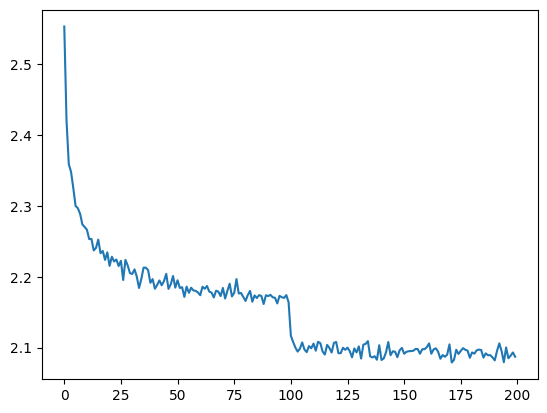

In [ ]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [53]:
for layer in model.layers:
    layer.training = False  # set to eval mode

In [54]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(f"{split} loss: {loss.item():.4f}")
split_loss('train')
split_loss('val')

train loss: 2.0618
val loss: 2.1052


In [56]:
# sample from the model
g = torch.Generator().manual_seed(2147483647+ 10)
for i in range(20):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(ix)
    print(''.join(itos[i] for i in out))

mora
mayanniellendyn
alee
threttegrace
azered
elin
shi
jen
edelisso
naraelynn
honelin
shubergiagriel
kin
renleigh
ter
fius
macder
yarue
ehs
kayshayveyah
